In [35]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [36]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('./sp500_all_5y.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

stock_apple = data[data.Ticker == 'AAPL']
stock_jpmorgan = data[data.Ticker == 'JPM']
stock_pfizer = data[data.Ticker == 'PFE']
scaler = MinMaxScaler(feature_range = (0, 1))

/Users/shengtaoli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [37]:
stock_apple=stock_apple.drop(['Unnamed: 0', 'Ticker'], axis=1)
stock_jpmorgan=stock_jpmorgan.drop(['Unnamed: 0', 'Ticker'], axis=1)
stock_pfizer=stock_pfizer.drop(['Unnamed: 0', 'Ticker'], axis=1)

In [38]:
data_size = stock_apple.shape[0]
training_size = math.floor(data_size * 0.8)
test_size = data_size - training_size

training_size
print(stock_apple.shape)
print(stock_jpmorgan.shape)
print(stock_pfizer.shape)

(1259, 5)
(1259, 5)
(1259, 5)


In [39]:
def split_training_test(data, training_size):
    return data.iloc[:training_size, 1:2].values, data.iloc[training_size:, 1:2].values
apple_training_set, apple_test_set = split_training_test(stock_apple, training_size)
apple_training_set_scaled = scaler.fit_transform(apple_training_set)

In [40]:



def form_train_xy(data, training_size):
    # 60 historical data predict current data
    X_train = []
    y_train = []
    for i in range(60, training_size):
        X_train.append(data[i-60:i, 0])
        y_train.append(data[i, 0])
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    return X_train, y_train

    
X_train_apple, y_train_apple = form_train_xy(apple_training_set_scaled, training_size)


In [42]:
def generate_model(X_train):
    model = Sequential()
    model.add(LSTM(units = 25, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 25, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 25, return_sequences = True))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 25))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    model.compile(optimizer= 'adam', loss='mean_squared_error')
    return model

apple_model = generate_model(X_train_apple)


In [43]:
apple_model.fit(X_train_apple, y_train_apple, epochs = 50, batch_size = 32)

Train on 947 samples
Epoch 1/50
947/947 [==============================] - 14s 15ms/sample - loss: 0.0529
Epoch 2/50
947/947 [==============================] - 7s 7ms/sample - loss: 0.0110
Epoch 3/50
947/947 [==============================] - 6s 7ms/sample - loss: 0.0080
Epoch 4/50
947/947 [==============================] - 6s 7ms/sample - loss: 0.0073
Epoch 5/50
947/947 [==============================] - 6s 7ms/sample - loss: 0.0080
Epoch 6/50
947/947 [==============================] - 6s 7ms/sample - loss: 0.0072
Epoch 7/50
947/947 [==============================] - 6s 7ms/sample - loss: 0.0066
Epoch 8/50
947/947 [==============================] - 7s 7ms/sample - loss: 0.0064
Epoch 9/50
947/947 [==============================] - 6s 7ms/sample - loss: 0.0068
Epoch 10/50
947/947 [==============================] - 6s 7ms/sample - loss: 0.0058
Epoch 11/50
947/947 [==============================] - 6s 7ms/sample - loss: 0.0053
Epoch 12/50
947/947 [==============================] - 6s 7ms/

In [52]:
def gen_X_test(stock, training_size, test_size):
    dataset_train = stock.iloc[:training_size, 3:4]
    dataset_test = stock.iloc[training_size:, 3:4]
    dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
    inputs= dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
    inputs = inputs.reshape(-1,1)
    inputs = scaler.transform(inputs)
    X_test = []
    for i in range(60, test_size+60):
        X_test.append(inputs[i-60:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    print(X_test.shape)
    return X_test, dataset_train, dataset_test

X_test_apple, dataset_train_apple, dataset_test_apple = gen_X_test(stock_apple, training_size, test_size)
predicted_stock_price_apple = apple_model.predict(X_test_apple)
predicted_stock_price_apple = scaler.inverse_transform(predicted_stock_price_apple)

(252, 60, 1)


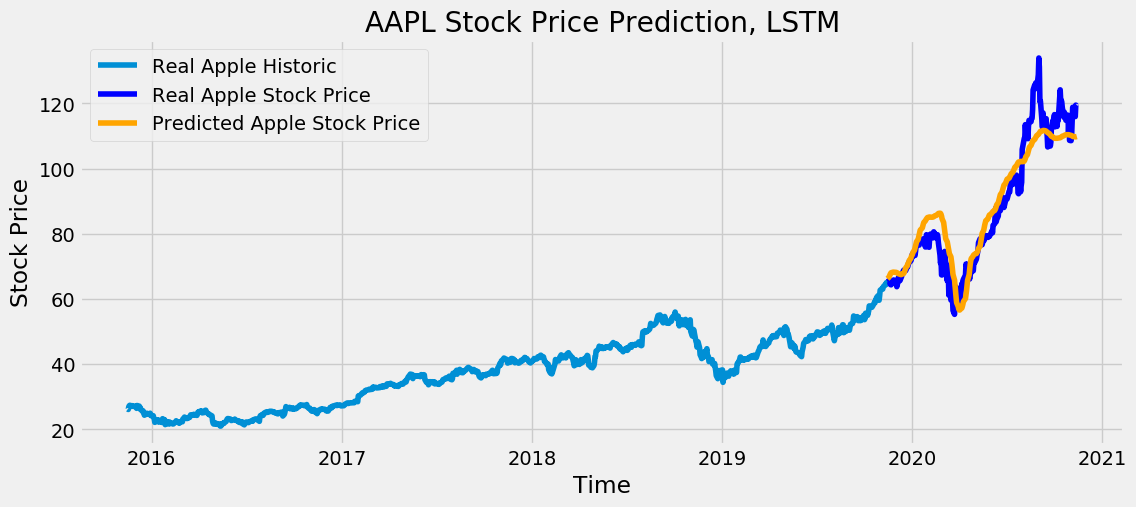

In [53]:
# Visualising the results
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5), dpi=100)
plt.plot(np.array(dataset_train_apple.index), np.array(dataset_train_apple), label = 'Real Apple Historic')
plt.plot(np.array(dataset_test_apple.index), dataset_test_apple.values, color = 'blue', label = 'Real Apple Stock Price')
plt.plot(np.array(dataset_test_apple.index), predicted_stock_price_apple, color = 'orange', label = 'Predicted Apple Stock Price')
plt.title('AAPL Stock Price Prediction, LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [54]:
# report performance
mse = mean_squared_error(predicted_stock_price_apple, dataset_test_apple)
print('MSE: '+str(mse))
mae = mean_absolute_error(predicted_stock_price_apple, dataset_test_apple)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(predicted_stock_price_apple, dataset_test_apple))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(dataset_test_apple - predicted_stock_price_apple)/np.abs(predicted_stock_price_apple))
print('MAPE: '+str(mape))

MSE: 45.51699169697312
MAE: 5.382032152206179
RMSE: 6.746628172426069
MAPE: Close    0.060554
dtype: float64


In [55]:
jpmorgan_training_set, jpmorgan_test_set = split_training_test(stock_jpmorgan, training_size)
jpmorgan_training_set_scaled = scaler.fit_transform(jpmorgan_training_set)
X_train_jpmorgan, y_train_jpmorgan = form_train_xy(jpmorgan_training_set_scaled, training_size)
jpmorgan_model = generate_model(X_train_jpmorgan)

In [56]:
jpmorgan_model.fit(X_train_jpmorgan, y_train_jpmorgan, epochs = 50, batch_size = 32)

Train on 947 samples
Epoch 1/50
947/947 [==============================] - 15s 16ms/sample - loss: 0.0760
Epoch 2/50
947/947 [==============================] - 6s 7ms/sample - loss: 0.0119
Epoch 3/50
947/947 [==============================] - 6s 7ms/sample - loss: 0.0094
Epoch 4/50
947/947 [==============================] - 7s 7ms/sample - loss: 0.0089
Epoch 5/50
947/947 [==============================] - 7s 7ms/sample - loss: 0.0082
Epoch 6/50
947/947 [==============================] - 7s 7ms/sample - loss: 0.0080
Epoch 7/50
947/947 [==============================] - 7s 7ms/sample - loss: 0.0075
Epoch 8/50
947/947 [==============================] - 8s 8ms/sample - loss: 0.0073
Epoch 9/50
947/947 [==============================] - 6s 7ms/sample - loss: 0.0068
Epoch 10/50
947/947 [==============================] - 7s 7ms/sample - loss: 0.0064
Epoch 11/50
947/947 [==============================] - 6s 7ms/sample - loss: 0.0066
Epoch 12/50
947/947 [==============================] - 6s 7ms/

In [57]:
X_test_jpmorgan, dataset_train_jpmorgan, dataset_test_jpmorgan = gen_X_test(stock_jpmorgan, training_size, test_size)
predicted_stock_price_jpmorgan = jpmorgan_model.predict(X_test_jpmorgan)
predicted_stock_price_jpmorgan = scaler.inverse_transform(predicted_stock_price_jpmorgan)

(252, 60, 1)


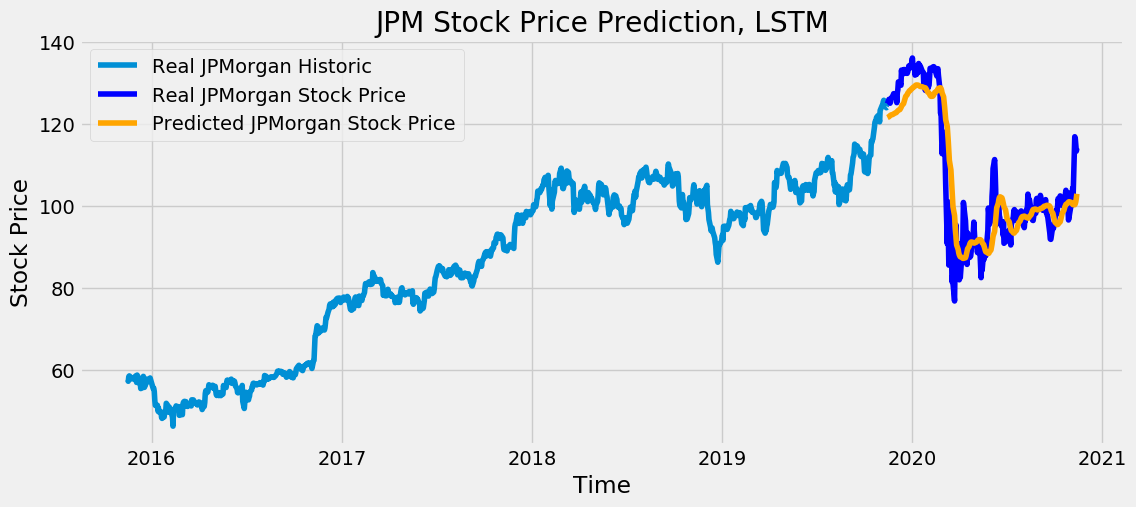

In [58]:
# Visualising the results
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5), dpi=100)
plt.plot(np.array(dataset_train_jpmorgan.index), np.array(dataset_train_jpmorgan), label = 'Real JPMorgan Historic')
plt.plot(np.array(dataset_test_jpmorgan.index), dataset_test_jpmorgan.values, color = 'blue', label = 'Real JPMorgan Stock Price')
plt.plot(np.array(dataset_test_jpmorgan.index), predicted_stock_price_jpmorgan, color = 'orange', label = 'Predicted JPMorgan Stock Price')
plt.title('JPM Stock Price Prediction, LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [59]:
# report performance
mse = mean_squared_error(predicted_stock_price_jpmorgan, dataset_test_jpmorgan)
print('MSE: '+str(mse))
mae = mean_absolute_error(predicted_stock_price_jpmorgan, dataset_test_jpmorgan)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(predicted_stock_price_jpmorgan, dataset_test_jpmorgan))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(dataset_test_jpmorgan - predicted_stock_price_jpmorgan)/np.abs(predicted_stock_price_jpmorgan))
print('MAPE: '+str(mape))

MSE: 50.1308076496886
MAE: 5.157526137336852
RMSE: 7.0803112678531726
MAPE: Close    0.048821
dtype: float64


In [60]:
pfizer_training_set, pfizer_test_set = split_training_test(stock_pfizer, training_size)
pfizer_training_set_scaled = scaler.fit_transform(pfizer_training_set)
X_train_pfizer, y_train_pfizer = form_train_xy(pfizer_training_set_scaled, training_size)
pfizer_model = generate_model(X_train_pfizer)

In [61]:
pfizer_model.fit(X_train_pfizer, y_train_pfizer, epochs = 50, batch_size = 32)

Train on 947 samples
Epoch 1/50
947/947 [==============================] - 14s 15ms/sample - loss: 0.0422
Epoch 2/50
947/947 [==============================] - 6s 7ms/sample - loss: 0.0124
Epoch 3/50
947/947 [==============================] - 7s 7ms/sample - loss: 0.0101
Epoch 4/50
947/947 [==============================] - 7s 7ms/sample - loss: 0.0094
Epoch 5/50
947/947 [==============================] - 7s 7ms/sample - loss: 0.0081
Epoch 6/50
947/947 [==============================] - 8s 8ms/sample - loss: 0.0085
Epoch 7/50
947/947 [==============================] - 7s 7ms/sample - loss: 0.0080
Epoch 8/50
947/947 [==============================] - 9s 10ms/sample - loss: 0.0078
Epoch 9/50
947/947 [==============================] - 8s 9ms/sample - loss: 0.0074
Epoch 10/50
947/947 [==============================] - 9s 9ms/sample - loss: 0.0069
Epoch 11/50
947/947 [==============================] - 6s 7ms/sample - loss: 0.0071
Epoch 12/50
947/947 [==============================] - 8s 8ms

In [62]:
X_test_pfizer, dataset_train_pfizer, dataset_test_pfizer = gen_X_test(stock_pfizer, training_size, test_size)
predicted_stock_price_pfizer = pfizer_model.predict(X_test_pfizer)
predicted_stock_price_pfizer = scaler.inverse_transform(predicted_stock_price_pfizer)

(252, 60, 1)


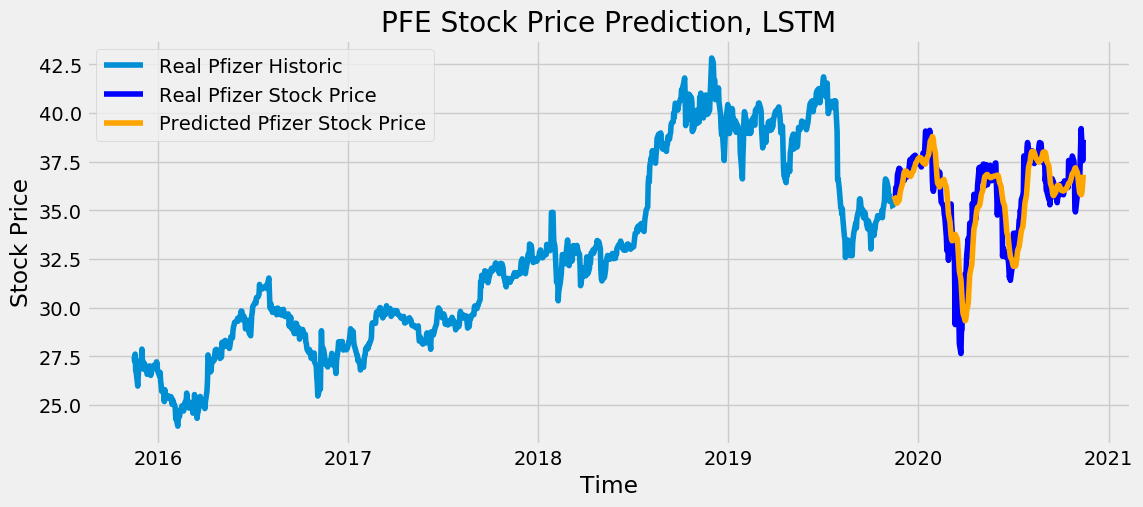

In [63]:
# Visualising the results
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5), dpi=100)
plt.plot(np.array(dataset_train_pfizer.index), np.array(dataset_train_pfizer), label = 'Real Pfizer Historic')
plt.plot(np.array(dataset_test_pfizer.index), dataset_test_pfizer.values, color = 'blue', label = 'Real Pfizer Stock Price')
plt.plot(np.array(dataset_test_pfizer.index), predicted_stock_price_pfizer, color = 'orange', label = 'Predicted Pfizer Stock Price')
plt.title('PFE Stock Price Prediction, LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [64]:
# report performance
mse = mean_squared_error(predicted_stock_price_pfizer, dataset_test_pfizer)
print('MSE: '+str(mse))
mae = mean_absolute_error(predicted_stock_price_pfizer, dataset_test_pfizer)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(predicted_stock_price_pfizer, dataset_test_pfizer))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(dataset_test_pfizer - predicted_stock_price_pfizer)/np.abs(predicted_stock_price_pfizer))
print('MAPE: '+str(mape))

MSE: 1.8548551638378845
MAE: 1.0334288657657689
RMSE: 1.3619306751218596
MAPE: Close    0.029675
dtype: float64
